
# Baseline Experiment 1

Train model from scratch for each subject. 

Model: BSFShallowNet

Dataset: BCI Competitin IV 2a, BCNI2014001 via MOABB library


In [1]:
import matplotlib.pyplot as plt
from braindecode.datasets import MOABBDataset
from numpy import multiply
from braindecode.preprocessing import (Preprocessor,
                                       exponential_moving_standardize,
                                       preprocess)
from braindecode.preprocessing import create_windows_from_events
import torch
from braindecode.models import ShallowFBCSPNet
from braindecode.util import set_random_seeds
from skorch.callbacks import LRScheduler
from skorch.helper import predefined_split
from braindecode import EEGClassifier
# from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
import os
import pickle
from matplotlib.lines import Line2D
# from braindecode.visualization import plot_confusion_matrix

from braindecode.datasets import BaseConcatDataset
from braindecode.datasets.base import EEGWindowsDataset
from braindecode.preprocessing.windowers import _create_windows_from_events
import numpy as np
import mne
import random

<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_types is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.pick_channels_regexp is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
<frozen importlib._bootstrap>:241: FutureWarning: mne.io.pick.channel_type is deprecated will be removed in 1.6, use documented public API instead. If no appropriate public API exists, please open an issue on GitHub.
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\moabb\pipelines\__init__.py:26: ModuleNotFoundError: Tensorflow is not installed. You won't be able to use these MOABB pipelines if you attempt to do so.
  warn(


## Loading and preparing the data




### Loading the dataset




In [2]:
dataset = MOABBDataset(dataset_name="BNCI2014_001", subject_ids=list(range(1, 10)))

### Preprocessing




In [3]:
low_cut_hz = 4.  # low cut frequency for filtering
high_cut_hz = 38.  # high cut frequency for filtering
# Parameters for exponential moving standardization
factor_new = 1e-3
init_block_size = 1000
# Factor to convert from V to uV
factor = 1e6

preprocessors = [
    Preprocessor('pick_types', eeg=True, meg=False, stim=False),  # Keep EEG sensors
    Preprocessor(lambda data: multiply(data, factor)),  # Convert from V to uV
    Preprocessor('filter', l_freq=low_cut_hz, h_freq=high_cut_hz),  # Bandpass filter
    Preprocessor(exponential_moving_standardize,  # Exponential moving standardization
                 factor_new=factor_new, init_block_size=init_block_size)
]

# Transform the data
preprocess(dataset, preprocessors, n_jobs=-1)

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\preprocessing\preprocess.py:55: UserWarning: Preprocessing choices with lambda functions cannot be saved.
  warn('Preprocessing choices with lambda functions cannot be saved.')


### Extracting Compute Windows




In [4]:
trial_start_offset_seconds = -0.5
# Extract sampling frequency, check that they are same in all datasets
sfreq = dataset.datasets[0].raw.info['sfreq']
assert all([ds.raw.info['sfreq'] == sfreq for ds in dataset.datasets])
# Calculate the trial start offset in samples.
trial_start_offset_samples = int(trial_start_offset_seconds * sfreq)

# Create windows using braindecode function for this. It needs parameters to define how
# trials should be used.
windows_dataset = create_windows_from_events(
    dataset,
    trial_start_offset_samples=trial_start_offset_samples,
    trial_stop_offset_samples=0,
    preload=True,
)

Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']
Used Annotations descriptions: ['feet', 'left_hand', 'right_hand', 'tongue']

In [5]:
def get_subset(window_set, target_trial_num):
    new_ds_lst = []
    
    for ds in window_set.datasets:
        cur_run_trial_num = len(ds.metadata)
        if target_trial_num > cur_run_trial_num:
            new_ds_lst.append(ds)
            target_trial_num -= cur_run_trial_num
        else:
            new_ds_lst.append(EEGWindowsDataset(ds.raw, ds.metadata[:target_trial_num], description=ds.description[:target_trial_num]))
            break

    return BaseConcatDataset(new_ds_lst)

## Model Pre-training

In [6]:
### Split dataset into pre-train set and fine-tune set
splitted_by_subj = windows_dataset.split('subject')
pre_train_subj = [1, 2, 3, 4, 5]
fine_tune_set = [6, 7, 8, 9]
pre_train_set = BaseConcatDataset([splitted_by_subj.get(f'{i}') for i in pre_train_subj])
fine_tune_set = BaseConcatDataset([splitted_by_subj.get(f'{i}') for i in fine_tune_set])

In [8]:
### Split pre-train set into pre-train-train set and pre-train-test set
pre_train_train_set_lst = []
pre_train_test_set_lst = []
pre_train_test_set_size = 1 # runs
for key, val in pre_train_set.split('subject').items():
    subj_splitted_lst_by_run = list(val.split('run').values())
    pre_train_train_set_lst.extend(subj_splitted_lst_by_run[:-pre_train_test_set_size])
    pre_train_test_set_lst.extend(subj_splitted_lst_by_run[-pre_train_test_set_size:])

pre_train_train_set = BaseConcatDataset(pre_train_train_set_lst)
pre_train_test_set = BaseConcatDataset(pre_train_test_set_lst)

In [9]:
cuda = torch.cuda.is_available()  # check if GPU is available, if True chooses to use it
device = 'cuda' if cuda else 'cpu'
if cuda:
    torch.backends.cudnn.benchmark = True

seed = 20200220
set_random_seeds(seed=seed, cuda=cuda)

n_classes = 4
classes = list(range(n_classes))
# Extract number of chans and time steps from dataset
n_chans = windows_dataset[0][0].shape[0]
input_window_samples = windows_dataset[0][0].shape[1]

cur_model = ShallowFBCSPNet(
    n_chans,
    n_classes,
    input_window_samples=input_window_samples,
    final_conv_length='auto',
)

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


In [10]:
lr = 0.07 * 0.01
weight_decay = 0
batch_size = 64
n_epochs = 30

# Re-initialize EEGClassifier
cur_clf = EEGClassifier(
    cur_model,
    criterion=torch.nn.NLLLoss,
    optimizer=torch.optim.AdamW,
    train_split=predefined_split(pre_train_test_set),  # using valid_set for validation
    optimizer__lr=lr,
    optimizer__weight_decay=weight_decay,
    batch_size=batch_size,
    callbacks=[
        "accuracy", ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=n_epochs - 1)),
    ],
    device=device,
    classes=classes,
    warm_start=False
)

In [11]:
_ = cur_clf.fit(pre_train_train_set, y=None, epochs=n_epochs)

  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
      1            0.3713        1.6246       0.3521            0.3521        1.4352  0.0007  4.2605
      2            0.4529        1.4494       0.3875            0.3875        1.3038  0.0007  5.0424
      3            0.4942        1.3483       0.4062            0.4062        1.3105  0.0007  4.6133
      4            0.5188        1.2806       0.4104            0.4104        1.2838  0.0007  4.1747
      5            0.5679        1.2352       0.4333            0.4333        1.2467  0.0007  4.5572
      6            0.5808        1.1860       0.4000            0.4000        1.2539  0.0006  4.1781
      7            0.6212        1.1197       0.4458            0.4458        1.2110  0.0006  4.3128
      8            0.6292        1.1099       0.4521            0.4521        1.2071  0.000

In [12]:
results_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir, 'results'))
exp_name = f'baseline_2_1_pretrain'
cur_clf.save_params(f_params=os.path.join(results_dir, f'{exp_name}_model.pkl'), 
                    f_optimizer=os.path.join(results_dir, f'{exp_name}_opt.pkl'), 
                    f_history=os.path.join(results_dir, f'{exp_name}_history.json'))

## Fine tuning
Take the pre-trained model and fine tune (continue training) with new data from unseen subject

In [13]:
### Split finetune set into finetune_train and finetune_valid
fine_tune_set_by_subj = fine_tune_set.split('subject')

data_amount_step = 20
results_columns = ['valid_accuracy',]
dict_results = {}

### Finetune for each subject in the finetune set
for finetune_subj_id, finetune_subj_set in fine_tune_set_by_subj.items():
    
    finetune_splitted_lst_by_run = list(finetune_subj_set.split('run').values())
    finetune_subj_train_set = BaseConcatDataset(finetune_splitted_lst_by_run[:-1])
    finetune_subj_valid_set = BaseConcatDataset(finetune_splitted_lst_by_run[-1:])

    ### Baseline accuracy on the finetune_valid set
    finetune_valid_predicted = cur_clf.predict(finetune_subj_valid_set)
    finetune_valid_true = np.array(finetune_subj_valid_set.get_metadata().target)
    finetune_baseline_correct = np.equal(finetune_valid_predicted, finetune_valid_true)
    finetune_baseline_acc = np.sum(finetune_baseline_correct) / len(finetune_baseline_correct)
    print(f'Before finetuning for subject {finetune_subj_id}, the baseline accuracy is {finetune_baseline_acc}')

    dict_subj_results = {0: finetune_baseline_acc}

    ### Finetune with different amount of new data
    finetune_trials_num = len(finetune_subj_train_set.get_metadata())
    for finetune_training_data_amount in np.arange(1, finetune_trials_num // data_amount_step) * data_amount_step:

        ## Get current finetune samples
        cur_finetune_subj_train_subset = get_subset(finetune_subj_train_set, finetune_training_data_amount)

        finetune_model = ShallowFBCSPNet(
            n_chans,
            n_classes,
            input_window_samples=input_window_samples,
            final_conv_length='auto',
        )

        finetune_lr = 0.0625 * 0.01
        finetune_weight_decay = 0
        finetune_batch_size = int(min(finetune_training_data_amount // 2, 64))
        finetune_n_epochs = 20
        
        new_clf = EEGClassifier(
            finetune_model,
            criterion=torch.nn.NLLLoss,
            optimizer=torch.optim.AdamW,
            train_split=predefined_split(finetune_subj_valid_set), 
            optimizer__lr=finetune_lr,
            optimizer__weight_decay=finetune_weight_decay,
            batch_size=finetune_batch_size,
            callbacks=[
                "accuracy", ("lr_scheduler", LRScheduler('CosineAnnealingLR', T_max=finetune_n_epochs - 1)),
            ],
            device=device,
            classes=classes,
        )
        new_clf.initialize()
        
        ## Load pretrained model
        new_clf.load_params(f_params=os.path.join(results_dir, f'{exp_name}_model.pkl'), 
                            f_optimizer=os.path.join(results_dir, f'{exp_name}_opt.pkl'), 
                            f_history=os.path.join(results_dir, f'{exp_name}_history.json'))

        ## Continue training / finetuning
        print(f'Fine tuning model for subject {finetune_subj_id} with {finetune_training_data_amount} trials')
        _ = new_clf.partial_fit(finetune_subj_train_set, y=None, epochs=finetune_n_epochs)

        ## Get results after fine tuning
        df = pd.DataFrame(new_clf.history[:, results_columns], columns=results_columns,
                          # index=new_clf.history[:, 'epoch'],
                         )

        cur_final_acc = np.mean(df.tail(5).valid_accuracy)
        dict_subj_results.update({finetune_training_data_amount: cur_final_acc})

    dict_results.update({finetune_subj_id: dict_subj_results})

Before finetuning for subject 6, the baseline accuracy is 0.2708333333333333
Fine tuning model for subject 6 with 20 trials


C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5667        1.6704       0.3438            0.3438        1.4737  0.0004  1.2052
     32            0.6813        1.2084       0.3646            0.3646        1.6763  0.0005  1.4153
     33            0.8042        0.9000       0.3438            0.3438        1.5461  0.0005  1.0939
     34            0.8271        0.8191       0.4271            0.4271        1.6537  0.0006  1.0935
     35            0.8812        0.7112       0.3854            0.3854        1.6616  0.0006  1.1568
     36            0.9167        0.6718       0.4271            0.4271        1.6516  0.0007  1.1917
     37            0.9500        0.5227       0.3646            0.3646        1.8200  0.0007  1.3058
     38            0.9417        0.4759       0.3333            0.3333        2.0015  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4958        1.5463       0.3438            0.3438        1.6052  0.0004  1.0915
     32            0.6562        1.1883       0.3542            0.3542        1.5101  0.0005  1.1720
     33            0.7208        0.9818       0.3646            0.3646        1.5308  0.0005  1.0802
     34            0.8042        0.8886       0.3958            0.3958        1.4613  0.0006  0.9280
     35            0.8667        0.7818       0.3750            0.3750        1.5365  0.0006  0.9376
     36            0.9042        0.6373       0.4167            0.4167        1.5868  0.0007  1.0437
     37            0.9313        0.5603       0.4062            0.4062        1.5689  0.0007  0.9981
     38            0.9688        0.5385       0.3646            0.3646        1.6480  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5042        1.6150       0.3333            0.3333        1.5637  0.0004  1.7271
     32            0.6542        1.2568       0.3646            0.3646        1.5097  0.0005  1.6003
     33            0.7542        0.9712       0.4375            0.4375        1.4471  0.0005  1.2773
     34            0.7937        0.8334       0.3333            0.3333        1.5793  0.0006  1.1043
     35            0.8708        0.7769       0.4062            0.4062        1.5180  0.0006  0.8901
     36            0.8833        0.6839       0.3750            0.3750        1.5029  0.0007  0.8767
     37            0.9042        0.5949       0.3646            0.3646        1.5383  0.0007  0.8771
     38            0.9104        0.5558       0.3542            0.3542        1.6151  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5292        1.6085       0.3750            0.3750        1.5556  0.0004  0.9784
     32            0.6104        1.2577       0.3646            0.3646        1.4311  0.0005  1.0201
     33            0.7083        1.0420       0.4062            0.4062        1.4002  0.0005  1.0211
     34            0.7604        0.9781       0.4167            0.4167        1.4601  0.0006  0.9039
     35            0.8292        0.8267       0.3958            0.3958        1.4439  0.0006  0.9140
     36            0.8625        0.7115       0.3958            0.3958        1.5555  0.0007  0.9430
     37            0.8833        0.6467       0.3646            0.3646        1.5227  0.0007  1.1311
     38            0.9125        0.5876       0.3438            0.3438        1.5497  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4313        1.5276       0.3125            0.3125        1.6392  0.0004  1.0366
     32            0.5458        1.3120       0.3229            0.3229        1.6009  0.0005  0.8350
     33            0.6312        1.1139       0.3438            0.3438        1.5527  0.0005  0.8708
     34            0.7104        1.0101       0.3542            0.3542        1.4497  0.0006  0.8534
     35            0.7562        0.9132       0.4167            0.4167        1.4222  0.0006  0.8439
     36            0.7958        0.8350       0.3750            0.3750        1.4712  0.0007  0.8291
     37            0.8542        0.7050       0.4271            0.4271        1.4699  0.0007  0.8445
     38            0.8958        0.6437       0.3750            0.3750        1.4456  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4146        1.5915       0.3542            0.3542        1.6983  0.0004  0.8828
     32            0.5396        1.3330       0.3333            0.3333        1.6213  0.0005  0.8912
     33            0.6104        1.1453       0.3542            0.3542        1.5606  0.0005  0.9218
     34            0.6771        0.9703       0.4062            0.4062        1.4913  0.0006  0.9988
     35            0.7604        0.9131       0.3646            0.3646        1.4763  0.0006  1.0458
     36            0.8042        0.8096       0.3646            0.3646        1.4504  0.0007  1.0932
     37            0.8333        0.6869       0.3438            0.3438        1.4837  0.0007  0.9377
     38            0.8792        0.6941       0.4062            0.4062        1.4644  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4354        1.6633       0.3125            0.3125        1.6374  0.0004  0.8062
     32            0.5125        1.3944       0.3229            0.3229        1.6282  0.0005  0.7768
     33            0.5687        1.2213       0.3750            0.3750        1.5812  0.0005  0.8083
     34            0.6792        1.0347       0.3854            0.3854        1.4837  0.0006  0.8042
     35            0.7167        0.9215       0.3958            0.3958        1.4466  0.0006  0.7976
     36            0.7792        0.8933       0.3750            0.3750        1.4778  0.0007  0.8013
     37            0.8104        0.7539       0.4062            0.4062        1.5364  0.0007  0.8024
     38            0.8479        0.7735       0.3958            0.3958        1.5362  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4250        1.6577       0.3021            0.3021        1.6256  0.0004  0.8394
     32            0.5229        1.4119       0.3229            0.3229        1.5544  0.0005  0.8456
     33            0.6042        1.1890       0.3646            0.3646        1.5200  0.0005  0.7950
     34            0.6646        1.0188       0.3854            0.3854        1.4748  0.0006  0.8802
     35            0.7312        0.9572       0.4167            0.4167        1.4337  0.0006  0.9376
     36            0.7708        0.8321       0.4062            0.4062        1.4876  0.0007  0.9712
     37            0.7896        0.7943       0.3958            0.3958        1.5183  0.0007  0.8855
     38            0.8354        0.7521       0.3750            0.3750        1.5516  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4396        1.6415       0.3438            0.3438        1.5994  0.0004  0.8271
     32            0.4875        1.3567       0.3333            0.3333        1.6385  0.0005  0.8334
     33            0.5958        1.1900       0.3438            0.3438        1.5633  0.0005  0.7859
     34            0.6708        1.0619       0.3958            0.3958        1.4666  0.0006  0.8441
     35            0.7167        0.9503       0.3646            0.3646        1.4613  0.0006  0.8441
     36            0.7646        0.8283       0.3750            0.3750        1.5145  0.0007  0.9075
     37            0.8021        0.8056       0.3646            0.3646        1.5189  0.0007  0.8844
     38            0.8521        0.7749       0.3958            0.3958        1.4708  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4042        1.6675       0.3125            0.3125        1.6238  0.0004  0.8138
     32            0.5271        1.3631       0.3438            0.3438        1.5975  0.0005  0.8130
     33            0.6083        1.1346       0.4062            0.4062        1.4533  0.0005  0.8472
     34            0.6750        1.0682       0.4271            0.4271        1.4581  0.0006  0.9682
     35            0.7125        0.9114       0.3958            0.3958        1.4931  0.0006  0.9301
     36            0.7604        0.8442       0.3542            0.3542        1.5015  0.0007  1.0220
     37            0.7979        0.7489       0.3750            0.3750        1.5073  0.0007  0.9700
     38            0.8313        0.7186       0.4271            0.4271        1.5033  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4188        1.6585       0.3438            0.3438        1.5836  0.0004  0.8025
     32            0.4979        1.4020       0.3333            0.3333        1.5499  0.0005  0.7651
     33            0.5958        1.1835       0.3958            0.3958        1.4854  0.0005  0.8089
     34            0.6750        1.0533       0.3854            0.3854        1.4231  0.0006  0.7959
     35            0.7312        0.8990       0.3854            0.3854        1.4337  0.0006  0.7657
     36            0.7604        0.8881       0.3854            0.3854        1.4708  0.0007  0.8539
     37            0.8083        0.8014       0.4062            0.4062        1.4402  0.0007  0.7986
     38            0.8417        0.7292       0.3854            0.3854        1.4698  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4188        1.5986       0.3229            0.3229        1.6034  0.0004  0.8674
     32            0.5167        1.3697       0.3438            0.3438        1.5906  0.0005  0.7953
     33            0.5958        1.1386       0.3750            0.3750        1.5187  0.0005  0.7803
     34            0.6500        1.0545       0.3854            0.3854        1.4498  0.0006  0.8269
     35            0.7188        0.9292       0.4271            0.4271        1.4295  0.0006  0.9789
     36            0.7646        0.8658       0.3958            0.3958        1.4506  0.0007  0.9096
     37            0.8021        0.7681       0.3646            0.3646        1.4708  0.0007  0.9729
     38            0.8292        0.7375       0.4167            0.4167        1.4920  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4250        1.6192       0.3125            0.3125        1.6402  0.0004  0.8024
     32            0.5396        1.3813       0.3229            0.3229        1.6004  0.0005  0.8078
     33            0.6333        1.1959       0.3125            0.3125        1.5359  0.0005  0.8170
     34            0.6333        0.9788       0.3438            0.3438        1.5216  0.0006  0.8189
     35            0.7125        0.9673       0.3958            0.3958        1.4493  0.0006  0.8256
     36            0.7917        0.8597       0.3958            0.3958        1.4425  0.0007  0.8022
     37            0.8313        0.7603       0.4375            0.4375        1.4537  0.0007  0.8094
     38            0.8083        0.6934       0.4375            0.4375        1.4986  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4125        1.6749       0.3333            0.3333        1.6323  0.0004  0.7976
     32            0.5250        1.4048       0.3229            0.3229        1.6145  0.0005  0.8282
     33            0.6000        1.2121       0.3646            0.3646        1.5453  0.0005  0.8181
     34            0.6896        1.0458       0.3958            0.3958        1.4665  0.0006  0.8515
     35            0.7438        0.9274       0.4062            0.4062        1.4425  0.0006  0.9789
     36            0.7833        0.8996       0.4479            0.4479        1.4458  0.0007  0.9472
     37            0.8313        0.7892       0.4167            0.4167        1.4260  0.0007  0.9344
     38            0.8542        0.6784       0.3958            0.3958        1.4409  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.3896        1.6306       0.3646            0.3646        1.5918  0.0004  0.7747
     32            0.5104        1.4355       0.3646            0.3646        1.5690  0.0005  0.7961
     33            0.6083        1.1406       0.3229            0.3229        1.4863  0.0005  0.8039
     34            0.6771        1.0318       0.4167            0.4167        1.4447  0.0006  0.8001
     35            0.7229        0.9817       0.4167            0.4167        1.4046  0.0006  0.7818
     36            0.7438        0.8425       0.4062            0.4062        1.4070  0.0007  0.8234
     37            0.7771        0.8071       0.3854            0.3854        1.4663  0.0007  0.7629
     38            0.8396        0.7374       0.3854            0.3854        1.4612  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4042        1.6377       0.3229            0.3229        1.6240  0.0004  0.7638
     32            0.5417        1.3883       0.3229            0.3229        1.5690  0.0005  0.7638
     33            0.5938        1.1265       0.3854            0.3854        1.5168  0.0005  0.7764
     34            0.6500        1.0599       0.3646            0.3646        1.5132  0.0006  0.7702
     35            0.7104        0.9261       0.3958            0.3958        1.5137  0.0006  0.7594
     36            0.7708        0.8636       0.3958            0.3958        1.5039  0.0007  0.9225
     37            0.7958        0.7876       0.3646            0.3646        1.5620  0.0007  0.9044
     38            0.8083        0.7670       0.3958            0.3958        1.6046  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4083        1.6080       0.3438            0.3438        1.5928  0.0004  1.0347
     32            0.4938        1.3365       0.2917            0.2917        1.5980  0.0005  0.8135
     33            0.6083        1.2052       0.3542            0.3542        1.4948  0.0005  0.8606
     34            0.6771        1.0346       0.4167            0.4167        1.4642  0.0006  0.8174
     35            0.7354        0.9261       0.3750            0.3750        1.4426  0.0006  0.8427
     36            0.8021        0.8756       0.3646            0.3646        1.4412  0.0007  0.8905
     37            0.8167        0.7866       0.4062            0.4062        1.4577  0.0007  0.8373
     38            0.8396        0.7159       0.4479            0.4479        1.4896  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4167        1.6554       0.3125            0.3125        1.6678  0.0004  0.8289
     32            0.5208        1.3538       0.3333            0.3333        1.6125  0.0005  0.8324
     33            0.6042        1.1509       0.3542            0.3542        1.5525  0.0005  0.7841
     34            0.6604        1.0030       0.3750            0.3750        1.4636  0.0006  0.7867
     35            0.7312        0.9413       0.4062            0.4062        1.4352  0.0006  0.8018
     36            0.7708        0.8300       0.4167            0.4167        1.4319  0.0007  0.9609
     37            0.8125        0.8375       0.4167            0.4167        1.4733  0.0007  0.8862
     38            0.8354        0.7314       0.3958            0.3958        1.4838  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4146        1.6866       0.3646            0.3646        1.6126  0.0004  1.1094
     32            0.5083        1.3313       0.3438            0.3438        1.6245  0.0005  0.8125
     33            0.6062        1.1287       0.3958            0.3958        1.5138  0.0005  0.8437
     34            0.6521        1.0287       0.4167            0.4167        1.5281  0.0006  0.8750
     35            0.6958        0.9109       0.4062            0.4062        1.5222  0.0006  0.8750
     36            0.7458        0.8599       0.4062            0.4062        1.4935  0.0007  0.8282
     37            0.8104        0.7773       0.4167            0.4167        1.4808  0.0007  0.8438
     38            0.8688        0.7528       0.4375            0.4375        1.4573  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4250        1.6754       0.3229            0.3229        1.6275  0.0004  0.8281
     32            0.5167        1.3324       0.3542            0.3542        1.5671  0.0005  0.8281
     33            0.5958        1.1969       0.3542            0.3542        1.4990  0.0005  0.8281
     34            0.6438        1.0386       0.3750            0.3750        1.4434  0.0006  0.9380
     35            0.7375        0.9365       0.4375            0.4375        1.3930  0.0006  0.9531
     36            0.7875        0.8548       0.4271            0.4271        1.4090  0.0007  0.9844
     37            0.8187        0.7752       0.4479            0.4479        1.4365  0.0007  1.0469
     38            0.8646        0.6763       0.4062            0.4062        1.4549  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4104        1.6672       0.3438            0.3438        1.5846  0.0004  0.9180
     32            0.5208        1.3818       0.3333            0.3333        1.6023  0.0005  0.8249
     33            0.6146        1.1568       0.3333            0.3333        1.5036  0.0005  0.8099
     34            0.6750        1.0304       0.3750            0.3750        1.4509  0.0006  1.0113
     35            0.7271        0.9316       0.4375            0.4375        1.3992  0.0006  0.8026
     36            0.7667        0.8523       0.4167            0.4167        1.4075  0.0007  0.8651
     37            0.8042        0.7850       0.4062            0.4062        1.4764  0.0007  0.7938
     38            0.8333        0.7171       0.3854            0.3854        1.5282  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4000        1.5470       0.3438            0.3438        1.6303  0.0004  0.9012
     32            0.4979        1.3956       0.3125            0.3125        1.7105  0.0005  0.9911
     33            0.6062        1.1862       0.3333            0.3333        1.5705  0.0005  1.1759
     34            0.6813        1.0010       0.3854            0.3854        1.4741  0.0006  0.9602
     35            0.7208        0.9036       0.4062            0.4062        1.4622  0.0006  0.9419
     36            0.7583        0.8741       0.4062            0.4062        1.4612  0.0007  0.8341
     37            0.8187        0.7975       0.3854            0.3854        1.5058  0.0007  0.7854
     38            0.8354        0.7247       0.4062            0.4062        1.4884  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4313        1.5974       0.3438            0.3438        1.6186  0.0004  0.8254
     32            0.4979        1.3602       0.3438            0.3438        1.6739  0.0005  0.8051
     33            0.6104        1.1585       0.3646            0.3646        1.5151  0.0005  0.8748
     34            0.6646        1.0845       0.3958            0.3958        1.4183  0.0006  0.8803
     35            0.7063        0.9624       0.4062            0.4062        1.4027  0.0006  0.7914
     36            0.7854        0.8319       0.3750            0.3750        1.4019  0.0007  0.7969
     37            0.8333        0.8127       0.3854            0.3854        1.4314  0.0007  0.8073
     38            0.8292        0.6814       0.4479            0.4479        1.4781  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6875        1.5629       0.5312            0.5312        1.1667  0.0004  1.6116
     32            0.7438        0.9721       0.4688            0.4688        1.3264  0.0005  1.3972
     33            0.8500        0.8613       0.4792            0.4792        1.2239  0.0005  1.3719
     34            0.9292        0.6430       0.6042            0.6042        1.0486  0.0006  1.2500
     35            0.9125        0.5316       0.5417            0.5417        1.1405  0.0006  1.3599
     36            0.9688        0.4124       0.5729            0.5729        1.0519  0.0007  1.3700
     37            0.9854        0.3653       0.6458            0.6458        0.9381  0.0007  1.3843
     38            0.9750        0.3097       0.6458            0.6458        0.9270  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6104        1.5120       0.4479            0.4479        1.3373  0.0004  1.2863
     32            0.7042        1.0409       0.5208            0.5208        1.2342  0.0005  1.0862
     33            0.7750        0.8223       0.5104            0.5104        1.2585  0.0005  1.2786
     34            0.9167        0.6376       0.5625            0.5625        1.1589  0.0006  1.2055
     35            0.9229        0.5442       0.5833            0.5833        1.1516  0.0006  1.1571
     36            0.9646        0.4639       0.6042            0.6042        1.0699  0.0007  0.9722
     37            0.9729        0.4106       0.5417            0.5417        1.0577  0.0007  1.0778
     38            0.9792        0.3360       0.5938            0.5938        1.1043  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5333        1.4868       0.4271            0.4271        1.3497  0.0004  2.1751
     32            0.7271        1.0975       0.4688            0.4688        1.2418  0.0005  2.0331
     33            0.8229        0.8767       0.5312            0.5312        1.1250  0.0005  1.0575
     34            0.8604        0.7551       0.4792            0.4792        1.2079  0.0006  1.9641
     35            0.8917        0.6562       0.5417            0.5417        1.1864  0.0006  1.0129
     36            0.8771        0.5452       0.5000            0.5000        1.2138  0.0007  1.2531
     37            0.9688        0.4987       0.5000            0.5000        1.0240  0.0007  1.2794
     38            0.9708        0.4109       0.6146            0.6146        0.9953  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.5646        1.5153       0.4375            0.4375        1.2478  0.0004  0.8784
     32            0.6750        1.1410       0.4896            0.4896        1.2042  0.0005  0.8773
     33            0.7500        0.9378       0.5104            0.5104        1.1750  0.0005  0.8778
     34            0.8458        0.8184       0.5729            0.5729        1.1352  0.0006  0.8786
     35            0.9000        0.6996       0.5417            0.5417        1.0850  0.0006  0.9094
     36            0.9167        0.5802       0.5625            0.5625        1.0790  0.0007  0.8926
     37            0.9604        0.5126       0.5729            0.5729        1.0428  0.0007  0.8773
     38            0.9229        0.4645       0.5521            0.5521        1.1339  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4688        1.4496       0.4583            0.4583        1.2287  0.0004  1.0742
     32            0.6250        1.2074       0.4792            0.4792        1.2093  0.0005  0.9765
     33            0.7292        1.0017       0.5208            0.5208        1.1410  0.0005  1.2023
     34            0.7833        0.8301       0.5417            0.5417        1.0624  0.0006  0.8873
     35            0.8417        0.7628       0.5312            0.5312        1.1586  0.0006  0.9486
     36            0.8792        0.6917       0.5208            0.5208        1.1142  0.0007  0.8606
     37            0.9146        0.6004       0.5625            0.5625        1.1106  0.0007  0.8650
     38            0.9313        0.5004       0.5312            0.5312        1.1014  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4604        1.4816       0.4062            0.4062        1.2548  0.0004  0.8484
     32            0.6333        1.2616       0.4375            0.4375        1.2030  0.0005  0.8459
     33            0.7146        1.0186       0.5104            0.5104        1.2280  0.0005  0.8439
     34            0.7750        0.9141       0.4896            0.4896        1.1382  0.0006  0.9388
     35            0.8313        0.7582       0.5208            0.5208        1.0971  0.0006  0.8912
     36            0.8625        0.7104       0.5521            0.5521        1.0948  0.0007  1.0652
     37            0.9104        0.5938       0.5521            0.5521        1.0682  0.0007  1.1522
     38            0.9125        0.5620       0.5417            0.5417        1.0871  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4562        1.5531       0.4479            0.4479        1.2616  0.0004  0.8132
     32            0.5604        1.2210       0.4271            0.4271        1.1983  0.0005  0.7812
     33            0.6813        1.0914       0.4792            0.4792        1.1704  0.0005  0.7974
     34            0.7708        0.8757       0.4583            0.4583        1.1530  0.0006  0.7815
     35            0.7979        0.8399       0.5208            0.5208        1.1316  0.0006  0.7969
     36            0.8167        0.7283       0.5104            0.5104        1.1509  0.0007  0.8437
     37            0.8771        0.6588       0.5833            0.5833        1.1089  0.0007  0.8681
     38            0.9062        0.5799       0.5729            0.5729        1.0742  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4396        1.5003       0.4271            0.4271        1.2819  0.0004  0.9312
     32            0.5854        1.3195       0.4375            0.4375        1.2157  0.0005  0.8022
     33            0.7083        1.0524       0.4896            0.4896        1.1750  0.0005  0.9011
     34            0.7396        0.9075       0.5208            0.5208        1.1698  0.0006  0.9052
     35            0.7688        0.8628       0.5104            0.5104        1.2073  0.0006  1.0690
     36            0.8229        0.7397       0.5208            0.5208        1.1690  0.0007  1.0684
     37            0.8771        0.6370       0.4896            0.4896        1.1571  0.0007  0.9237
     38            0.9250        0.5662       0.5104            0.5104        1.0960  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4250        1.5183       0.3958            0.3958        1.2810  0.0004  0.9974
     32            0.5583        1.2889       0.4583            0.4583        1.1905  0.0005  0.8663
     33            0.6542        1.0644       0.4479            0.4479        1.2410  0.0005  0.9825
     34            0.7417        0.9802       0.4792            0.4792        1.1753  0.0006  0.8944
     35            0.7812        0.8616       0.4896            0.4896        1.1361  0.0006  0.9063
     36            0.8438        0.7162       0.5312            0.5312        1.1212  0.0007  0.8685
     37            0.8688        0.6578       0.5417            0.5417        1.1014  0.0007  0.9297
     38            0.9083        0.6063       0.5417            0.5417        1.0648  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4333        1.5057       0.3958            0.3958        1.3011  0.0004  1.0126
     32            0.5687        1.3263       0.4271            0.4271        1.2107  0.0005  1.0726
     33            0.6937        1.0856       0.4688            0.4688        1.1535  0.0005  1.1696
     34            0.7667        0.9452       0.5104            0.5104        1.1248  0.0006  0.9469
     35            0.8063        0.8273       0.5104            0.5104        1.1223  0.0006  0.7818
     36            0.8354        0.6822       0.5208            0.5208        1.1022  0.0007  0.7973
     37            0.8708        0.6029       0.5625            0.5625        1.0749  0.0007  0.7974
     38            0.9083        0.6151       0.5625            0.5625        1.0365  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4625        1.5179       0.3958            0.3958        1.2783  0.0004  0.7969
     32            0.5833        1.2523       0.4688            0.4688        1.2003  0.0005  0.7812
     33            0.6979        1.0855       0.4792            0.4792        1.1747  0.0005  0.7968
     34            0.7438        0.8801       0.5000            0.5000        1.1476  0.0006  0.7817
     35            0.8313        0.8150       0.5625            0.5625        1.0792  0.0006  0.7718
     36            0.8521        0.7532       0.5729            0.5729        1.0970  0.0007  0.7818
     37            0.8854        0.6101       0.5312            0.5312        1.0823  0.0007  0.7974
     38            0.9083        0.5647       0.5833            0.5833        1.0842  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4250        1.5153       0.4375            0.4375        1.3274  0.0004  0.7813
     32            0.5979        1.3238       0.4375            0.4375        1.2341  0.0005  0.9535
     33            0.6833        1.1141       0.4688            0.4688        1.2281  0.0005  0.9375
     34            0.7479        0.9307       0.4792            0.4792        1.1868  0.0006  0.9062
     35            0.7958        0.8419       0.5312            0.5312        1.1663  0.0006  0.9383
     36            0.8521        0.7222       0.5417            0.5417        1.1369  0.0007  0.8281
     37            0.8958        0.6625       0.5833            0.5833        1.0709  0.0007  0.7817
     38            0.9146        0.5722       0.5521            0.5521        1.1005  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4583        1.5435       0.4062            0.4062        1.2640  0.0004  0.7813
     32            0.5875        1.2679       0.4167            0.4167        1.2087  0.0005  0.7980
     33            0.6667        1.0659       0.4583            0.4583        1.1660  0.0005  0.7818
     34            0.7479        0.9160       0.5312            0.5312        1.1806  0.0006  0.7812
     35            0.8042        0.8039       0.5208            0.5208        1.2091  0.0006  0.7969
     36            0.8375        0.7292       0.5417            0.5417        1.1603  0.0007  0.7973
     37            0.8750        0.6376       0.5625            0.5625        1.1287  0.0007  0.7993
     38            0.9021        0.6190       0.5625            0.5625        1.0890  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4479        1.5290       0.4062            0.4062        1.2861  0.0004  0.7969
     32            0.5813        1.2084       0.4479            0.4479        1.1934  0.0005  0.7969
     33            0.7021        1.0385       0.4479            0.4479        1.1524  0.0005  0.7973
     34            0.7458        0.9082       0.4896            0.4896        1.1455  0.0006  0.9063
     35            0.8083        0.7833       0.5312            0.5312        1.1270  0.0006  0.9219
     36            0.8500        0.7121       0.5312            0.5312        1.1312  0.0007  0.9063
     37            0.8479        0.6358       0.5312            0.5312        1.1587  0.0007  0.7817
     38            0.9146        0.6209       0.5521            0.5521        1.1323  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4333        1.5223       0.4062            0.4062        1.3009  0.0004  0.7817
     32            0.5687        1.3370       0.4062            0.4062        1.2458  0.0005  0.7973
     33            0.6687        1.0880       0.4375            0.4375        1.1972  0.0005  0.7817
     34            0.7562        0.9658       0.5104            0.5104        1.1849  0.0006  0.7812
     35            0.8042        0.8714       0.4688            0.4688        1.1656  0.0006  0.7812
     36            0.8333        0.7131       0.4792            0.4792        1.1423  0.0007  0.8125
     37            0.8771        0.6710       0.4792            0.4792        1.1455  0.0007  0.7813
     38            0.8917        0.5644       0.5104            0.5104        1.0737  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4604        1.5097       0.3958            0.3958        1.3030  0.0004  0.7818
     32            0.5813        1.2451       0.4271            0.4271        1.2510  0.0005  0.7813
     33            0.6646        1.0665       0.4896            0.4896        1.1870  0.0005  0.7817
     34            0.7646        0.9611       0.5417            0.5417        1.1457  0.0006  0.7819
     35            0.8063        0.8120       0.5521            0.5521        1.1390  0.0006  0.9062
     36            0.8354        0.6909       0.5729            0.5729        1.2029  0.0007  0.9063
     37            0.8917        0.6391       0.5417            0.5417        1.1543  0.0007  0.8906
     38            0.9042        0.5622       0.5625            0.5625        1.0801  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4521        1.5457       0.3854            0.3854        1.2758  0.0004  0.9532
     32            0.6167        1.2871       0.4479            0.4479        1.1891  0.0005  0.8129
     33            0.7000        1.0581       0.5000            0.5000        1.1789  0.0005  0.7970
     34            0.7646        0.9354       0.5104            0.5104        1.1777  0.0006  0.8442
     35            0.8125        0.7975       0.5104            0.5104        1.1254  0.0006  0.8443
     36            0.8438        0.7204       0.5208            0.5208        1.1164  0.0007  0.7974
     37            0.8542        0.6609       0.5312            0.5312        1.1114  0.0007  0.7817
     38            0.9083        0.6545       0.5729            0.5729        1.0445  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4542        1.5436       0.3854            0.3854        1.2826  0.0004  0.7817
     32            0.5875        1.2990       0.4583            0.4583        1.2070  0.0005  0.7980
     33            0.6979        1.0705       0.4688            0.4688        1.2154  0.0005  0.7968
     34            0.7583        0.9324       0.5000            0.5000        1.1874  0.0006  0.7813
     35            0.7792        0.8378       0.5000            0.5000        1.1143  0.0006  0.7969
     36            0.8125        0.7281       0.5625            0.5625        1.0842  0.0007  0.8598
     37            0.8583        0.6520       0.5729            0.5729        1.1327  0.0007  0.9688
     38            0.8896        0.6146       0.5833            0.5833        1.0856  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4750        1.5239       0.4167            0.4167        1.2677  0.0004  0.9375
     32            0.5854        1.3554       0.5000            0.5000        1.2405  0.0005  0.9688
     33            0.6750        1.0421       0.5312            0.5312        1.1517  0.0005  0.8131
     34            0.7792        0.9169       0.5521            0.5521        1.1277  0.0006  0.7974
     35            0.8125        0.8109       0.5417            0.5417        1.1319  0.0006  0.7818
     36            0.8625        0.7584       0.5417            0.5417        1.1726  0.0007  0.7969
     37            0.8812        0.6282       0.5312            0.5312        1.1250  0.0007  0.7978
     38            0.9042        0.5989       0.5208            0.5208        1.1098  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4583        1.5694       0.4062            0.4062        1.2728  0.0004  0.7969
     32            0.5750        1.2516       0.4583            0.4583        1.2164  0.0005  0.7817
     33            0.7208        1.0171       0.5000            0.5000        1.1655  0.0005  0.7974
     34            0.7479        0.9176       0.4792            0.4792        1.1753  0.0006  0.7969
     35            0.7917        0.8550       0.5208            0.5208        1.1555  0.0006  0.8906
     36            0.8583        0.7160       0.5312            0.5312        1.0950  0.0007  0.7818
     37            0.8750        0.6407       0.5938            0.5938        1.0762  0.0007  0.7813
     38            0.9062        0.5983       0.6146            0.6146        1.0838  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4625        1.5186       0.4167            0.4167        1.2758  0.0004  0.8281
     32            0.5875        1.2529       0.4479            0.4479        1.1680  0.0005  0.9869
     33            0.6750        1.0820       0.4792            0.4792        1.1635  0.0005  0.9062
     34            0.7396        0.9673       0.5104            0.5104        1.1921  0.0006  0.9225
     35            0.8063        0.8127       0.5521            0.5521        1.1458  0.0006  0.7973
     36            0.8438        0.7144       0.5625            0.5625        1.1264  0.0007  0.7817
     37            0.8938        0.6313       0.5833            0.5833        1.0946  0.0007  0.7969
     38            0.9021        0.6005       0.5521            0.5521        1.0795  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4375        1.4770       0.4062            0.4062        1.2755  0.0004  0.9918
     32            0.5958        1.2608       0.4479            0.4479        1.2070  0.0005  0.8150
     33            0.6875        1.0528       0.4583            0.4583        1.2032  0.0005  0.7919
     34            0.7521        0.9421       0.4688            0.4688        1.1909  0.0006  0.9147
     35            0.8146        0.8354       0.5208            0.5208        1.1222  0.0006  0.8923
     36            0.8354        0.7425       0.5417            0.5417        1.1265  0.0007  0.8981
     37            0.8708        0.6653       0.5104            0.5104        1.1320  0.0007  0.8982
     38            0.9104        0.5856       0.5417            0.5417        1.0592  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.4667        1.5463       0.4062            0.4062        1.2503  0.0004  1.0242
     32            0.5854        1.2534       0.4688            0.4688        1.2093  0.0005  1.0521
     33            0.6417        1.1098       0.4479            0.4479        1.1950  0.0005  1.0416
     34            0.7417        0.9163       0.4792            0.4792        1.1728  0.0006  0.8300
     35            0.8063        0.7965       0.5000            0.5000        1.1741  0.0006  0.8257
     36            0.8417        0.7688       0.5521            0.5521        1.0953  0.0007  0.8313
     37            0.8792        0.6726       0.5833            0.5833        1.0948  0.0007  0.8351
     38            0.9083        0.6295       0.5208            0.5208        1.1132  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7479        1.1390       0.5104            0.5104        1.2512  0.0004  1.2248
     32            0.7604        0.8576       0.5312            0.5312        1.0827  0.0005  1.2046
     33            0.8187        0.6719       0.4479            0.4479        1.2862  0.0005  1.2753
     34            0.9104        0.6105       0.5833            0.5833        1.1377  0.0006  1.3284
     35            0.9271        0.4667       0.5208            0.5208        1.1279  0.0006  1.6650
     36            0.9479        0.4257       0.5104            0.5104        1.1171  0.0007  1.2025
     37            0.9458        0.4144       0.5729            0.5729        1.2043  0.0007  1.1975
     38            0.9625        0.3477       0.6250            0.6250        1.1338  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6937        1.1607       0.5625            0.5625        1.2652  0.0004  1.0033
     32            0.8042        0.8355       0.5104            0.5104        1.1699  0.0005  1.1438
     33            0.8292        0.6750       0.6042            0.6042        1.1357  0.0005  1.1460
     34            0.9021        0.5574       0.5417            0.5417        1.1111  0.0006  1.5205
     35            0.9229        0.4978       0.5312            0.5312        1.2239  0.0006  1.4322
     36            0.9208        0.4731       0.5417            0.5417        1.1679  0.0007  1.8458
     37            0.9458        0.4037       0.6354            0.6354        1.0688  0.0007  1.5930
     38            0.9354        0.3419       0.5625            0.5625        1.1598  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6896        1.1803       0.5104            0.5104        1.2203  0.0004  1.3000
     32            0.7708        0.8191       0.5521            0.5521        1.1895  0.0005  1.1422
     33            0.8396        0.6672       0.5417            0.5417        1.0983  0.0005  0.9933
     34            0.8875        0.5642       0.5521            0.5521        1.0421  0.0006  1.0591
     35            0.9125        0.4954       0.5208            0.5208        1.0950  0.0006  0.9545
     36            0.9333        0.4146       0.5625            0.5625        1.1206  0.0007  0.9075
     37            0.9333        0.3838       0.5417            0.5417        1.1775  0.0007  0.9229
     38            0.9583        0.3451       0.5417            0.5417        1.1501  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6104        1.1611       0.4688            0.4688        1.3480  0.0004  0.9327
     32            0.7438        0.8624       0.5521            0.5521        1.1919  0.0005  0.9156
     33            0.8042        0.7048       0.5625            0.5625        1.1771  0.0005  0.9505
     34            0.8771        0.6227       0.5625            0.5625        1.0962  0.0006  1.2479
     35            0.9062        0.5313       0.5625            0.5625        1.0799  0.0006  1.7214
     36            0.9187        0.4491       0.5625            0.5625        1.1525  0.0007  1.1301
     37            0.9313        0.4393       0.5938            0.5938        1.0745  0.0007  1.0282
     38            0.9417        0.3812       0.5417            0.5417        1.1318  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6375        1.1959       0.4792            0.4792        1.1464  0.0004  0.9371
     32            0.7146        0.9246       0.5312            0.5312        1.2404  0.0005  0.9850
     33            0.7583        0.7890       0.5833            0.5833        1.2532  0.0005  1.1040
     34            0.8333        0.6762       0.5208            0.5208        1.1262  0.0006  1.0614
     35            0.8521        0.5847       0.5729            0.5729        1.1156  0.0006  1.1872
     36            0.9000        0.5526       0.5833            0.5833        1.0931  0.0007  1.3484
     37            0.9062        0.4578       0.6250            0.6250        1.0656  0.0007  1.1093
     38            0.9375        0.4275       0.5625            0.5625        1.0950  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6167        1.2024       0.4792            0.4792        1.1631  0.0004  0.8959
     32            0.6771        0.9625       0.5312            0.5312        1.2736  0.0005  0.9661
     33            0.7396        0.8265       0.5729            0.5729        1.1961  0.0005  0.9612
     34            0.8083        0.6712       0.5625            0.5625        1.1437  0.0006  0.9518
     35            0.8625        0.6009       0.5521            0.5521        1.0780  0.0006  1.0941
     36            0.8583        0.5571       0.5833            0.5833        1.0890  0.0007  0.9934
     37            0.9000        0.4657       0.5625            0.5625        1.0706  0.0007  1.0000
     38            0.9187        0.4374       0.6042            0.6042        1.0744  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6396        1.2537       0.4792            0.4792        1.1069  0.0004  1.0970
     32            0.6917        1.0460       0.4792            0.4792        1.2151  0.0005  0.8863
     33            0.7292        0.8158       0.5417            0.5417        1.2049  0.0005  0.8511
     34            0.7958        0.7445       0.5833            0.5833        1.1316  0.0006  0.9583
     35            0.8417        0.6109       0.5729            0.5729        1.0750  0.0006  0.8132
     36            0.8604        0.5375       0.5625            0.5625        1.0524  0.0007  0.8327
     37            0.8625        0.5148       0.5625            0.5625        1.0742  0.0007  0.7962
     38            0.9187        0.4908       0.5729            0.5729        1.0825  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6229        1.1483       0.4792            0.4792        1.1472  0.0004  0.8345
     32            0.7042        0.9721       0.5000            0.5000        1.2387  0.0005  0.8025
     33            0.7500        0.8585       0.5729            0.5729        1.2500  0.0005  0.8492
     34            0.7792        0.7035       0.5625            0.5625        1.1715  0.0006  0.8780
     35            0.8313        0.6440       0.5625            0.5625        1.1062  0.0006  0.8250
     36            0.8292        0.5776       0.5521            0.5521        1.1062  0.0007  1.0594
     37            0.9021        0.4970       0.5625            0.5625        1.0805  0.0007  0.9357
     38            0.9146        0.4683       0.5521            0.5521        1.0925  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6292        1.1813       0.5312            0.5312        1.0866  0.0004  0.8534
     32            0.6854        0.9752       0.5000            0.5000        1.1671  0.0005  0.8012
     33            0.7208        0.8009       0.5312            0.5312        1.2963  0.0005  0.8366
     34            0.7917        0.6857       0.5625            0.5625        1.1912  0.0006  0.8559
     35            0.8354        0.6147       0.5521            0.5521        1.1358  0.0006  1.1354
     36            0.8562        0.5572       0.5625            0.5625        1.1559  0.0007  0.8446
     37            0.8792        0.5201       0.5729            0.5729        1.1093  0.0007  0.7912
     38            0.8917        0.4714       0.5729            0.5729        1.0946  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6333        1.2844       0.5104            0.5104        1.1068  0.0004  0.8867
     32            0.7042        0.9915       0.5000            0.5000        1.1609  0.0005  0.8018
     33            0.7250        0.8748       0.5521            0.5521        1.2002  0.0005  0.7976
     34            0.7833        0.7232       0.5625            0.5625        1.0995  0.0006  0.9561
     35            0.8375        0.6497       0.5417            0.5417        1.0706  0.0006  1.0172
     36            0.8583        0.5364       0.5417            0.5417        1.0939  0.0007  0.9559
     37            0.8938        0.5025       0.6042            0.6042        1.1067  0.0007  0.8561
     38            0.9125        0.4445       0.5729            0.5729        1.1095  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6292        1.2198       0.4792            0.4792        1.1155  0.0004  0.9257
     32            0.6979        0.9276       0.5000            0.5000        1.1803  0.0005  0.9397
     33            0.7188        0.7754       0.5521            0.5521        1.2307  0.0005  0.7993
     34            0.7729        0.7262       0.5625            0.5625        1.1172  0.0006  0.7817
     35            0.8292        0.6405       0.5417            0.5417        1.0665  0.0006  0.7818
     36            0.8542        0.5385       0.5729            0.5729        1.1134  0.0007  0.7813
     37            0.8938        0.5056       0.5833            0.5833        1.1191  0.0007  0.7812
     38            0.9021        0.4836       0.5938            0.5938        1.1169  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6396        1.2404       0.4792            0.4792        1.1005  0.0004  0.7817
     32            0.7000        0.9569       0.4896            0.4896        1.1441  0.0005  0.7973
     33            0.7417        0.8301       0.5417            0.5417        1.2360  0.0005  0.7969
     34            0.7917        0.7344       0.5833            0.5833        1.1863  0.0006  0.9063
     35            0.8083        0.6370       0.5625            0.5625        1.1258  0.0006  0.8906
     36            0.8604        0.5558       0.5625            0.5625        1.0915  0.0007  0.9380
     37            0.8875        0.4722       0.6042            0.6042        1.0810  0.0007  0.9219
     38            0.9208        0.4803       0.5625            0.5625        1.1024  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6354        1.1983       0.4896            0.4896        1.1144  0.0004  0.7817
     32            0.6771        0.9974       0.5000            0.5000        1.1960  0.0005  0.7973
     33            0.7562        0.7968       0.5417            0.5417        1.1601  0.0005  0.8135
     34            0.8000        0.7050       0.5625            0.5625        1.1301  0.0006  0.7819
     35            0.8167        0.6567       0.5625            0.5625        1.1220  0.0006  0.7812
     36            0.8625        0.5297       0.5417            0.5417        1.0663  0.0007  0.7813
     37            0.8917        0.5288       0.5833            0.5833        1.0728  0.0007  0.7969
     38            0.9125        0.4717       0.6042            0.6042        1.0650  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6333        1.1937       0.4792            0.4792        1.1198  0.0004  0.7974
     32            0.6917        1.0194       0.5000            0.5000        1.1575  0.0005  0.7813
     33            0.7625        0.8077       0.5312            0.5312        1.1693  0.0005  0.7817
     34            0.8313        0.6868       0.5417            0.5417        1.1006  0.0006  0.7818
     35            0.8521        0.5886       0.5521            0.5521        1.0815  0.0006  0.8437
     36            0.8729        0.5217       0.5625            0.5625        1.0569  0.0007  0.9063
     37            0.8708        0.5037       0.5938            0.5938        1.1080  0.0007  0.9375
     38            0.8938        0.4521       0.6042            0.6042        1.1204  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6188        1.2199       0.4583            0.4583        1.1200  0.0004  0.9063
     32            0.6937        0.9456       0.4688            0.4688        1.1410  0.0005  0.9375
     33            0.7312        0.8158       0.5729            0.5729        1.1758  0.0005  0.7980
     34            0.7688        0.6679       0.5729            0.5729        1.1576  0.0006  0.7973
     35            0.8292        0.6360       0.5312            0.5312        1.0915  0.0006  0.7817
     36            0.8771        0.5326       0.5833            0.5833        1.0698  0.0007  0.7818
     37            0.8979        0.4631       0.6042            0.6042        1.0402  0.0007  0.7812
     38            0.9000        0.4712       0.6042            0.6042        1.0505  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6396        1.2096       0.5000            0.5000        1.1318  0.0004  0.7812
     32            0.6708        0.9843       0.5104            0.5104        1.2248  0.0005  0.7817
     33            0.7479        0.8166       0.5417            0.5417        1.2106  0.0005  0.7969
     34            0.7771        0.6703       0.5312            0.5312        1.1522  0.0006  0.7817
     35            0.8167        0.6423       0.5312            0.5312        1.0824  0.0006  0.7813
     36            0.8583        0.5604       0.5729            0.5729        1.0672  0.0007  0.7816
     37            0.9000        0.5207       0.5729            0.5729        1.0644  0.0007  0.8926
     38            0.9104        0.4677       0.5833            0.5833        1.0812  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6229        1.2422       0.4896            0.4896        1.1203  0.0004  0.9844
     32            0.7042        1.0240       0.5208            0.5208        1.1450  0.0005  0.9375
     33            0.7562        0.8257       0.5417            0.5417        1.1769  0.0005  1.0000
     34            0.8021        0.6974       0.5625            0.5625        1.1402  0.0006  0.7970
     35            0.8250        0.6265       0.5521            0.5521        1.1120  0.0006  0.7817
     36            0.8521        0.5561       0.5729            0.5729        1.0811  0.0007  0.9063
     37            0.9021        0.5217       0.5833            0.5833        1.0698  0.0007  0.8438
     38            0.9083        0.4238       0.6042            0.6042        1.1176  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6312        1.2005       0.4792            0.4792        1.1232  0.0004  0.8130
     32            0.6958        0.9781       0.4688            0.4688        1.2072  0.0005  0.7814
     33            0.7375        0.8472       0.5312            0.5312        1.2535  0.0005  0.7812
     34            0.7625        0.6859       0.5521            0.5521        1.2521  0.0006  0.7812
     35            0.8104        0.6117       0.5521            0.5521        1.1788  0.0006  0.7813
     36            0.8688        0.5741       0.5938            0.5938        1.1346  0.0007  0.8131
     37            0.8938        0.4809       0.5729            0.5729        1.1229  0.0007  0.8126
     38            0.9146        0.4645       0.5833            0.5833        1.1045  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6312        1.2347       0.4688            0.4688        1.1129  0.0004  0.7830
     32            0.7125        1.0077       0.5000            0.5000        1.1450  0.0005  0.9063
     33            0.7562        0.7976       0.5312            0.5312        1.1964  0.0005  0.8599
     34            0.7833        0.6917       0.5729            0.5729        1.1677  0.0006  0.9844
     35            0.8271        0.6132       0.5625            0.5625        1.0884  0.0006  0.8750
     36            0.8750        0.5841       0.5417            0.5417        1.0758  0.0007  0.8282
     37            0.9083        0.5045       0.5521            0.5521        1.0564  0.0007  0.7734
     38            0.9146        0.4561       0.6354            0.6354        1.0730  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6354        1.2339       0.5104            0.5104        1.1411  0.0004  0.7969
     32            0.6937        0.9274       0.4896            0.4896        1.1861  0.0005  0.8126
     33            0.7562        0.8361       0.5521            0.5521        1.1758  0.0005  0.7817
     34            0.7958        0.7360       0.5729            0.5729        1.1165  0.0006  0.7974
     35            0.8229        0.6221       0.5417            0.5417        1.0915  0.0006  0.7974
     36            0.8438        0.5431       0.5938            0.5938        1.0846  0.0007  0.7969
     37            0.8646        0.5215       0.6042            0.6042        1.0811  0.0007  0.7813
     38            0.9104        0.4688       0.5521            0.5521        1.0841  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6354        1.2104       0.5104            0.5104        1.1150  0.0004  0.7815
     32            0.6625        0.9611       0.5208            0.5208        1.3017  0.0005  0.7812
     33            0.7229        0.8111       0.5208            0.5208        1.3434  0.0005  0.8125
     34            0.8083        0.7366       0.5729            0.5729        1.1512  0.0006  0.9531
     35            0.8333        0.6416       0.5625            0.5625        1.0979  0.0006  0.9062
     36            0.8646        0.5451       0.5833            0.5833        1.0854  0.0007  0.9844
     37            0.8750        0.5078       0.5833            0.5833        1.0863  0.0007  0.7823
     38            0.9125        0.4750       0.5625            0.5625        1.0791  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6396        1.2315       0.5000            0.5000        1.1000  0.0004  0.7817
     32            0.6875        1.0143       0.5000            0.5000        1.1800  0.0005  0.7817
     33            0.7000        0.8396       0.5625            0.5625        1.3024  0.0005  1.0005
     34            0.7729        0.6748       0.5833            0.5833        1.2762  0.0006  0.7969
     35            0.8313        0.5975       0.5521            0.5521        1.1539  0.0006  0.7823
     36            0.8562        0.6076       0.5417            0.5417        1.1362  0.0007  0.7811
     37            0.8833        0.5086       0.5417            0.5417        1.1031  0.0007  0.7814
     38            0.9062        0.4867       0.5625            0.5625        1.0790  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6104        1.2103       0.5208            0.5208        1.1101  0.0004  0.7973
     32            0.7000        0.9964       0.5104            0.5104        1.1574  0.0005  0.8129
     33            0.7354        0.8387       0.5312            0.5312        1.2485  0.0005  0.7813
     34            0.7750        0.7280       0.5625            0.5625        1.2214  0.0006  0.7969
     35            0.7958        0.6574       0.5521            0.5521        1.1522  0.0006  0.9531
     36            0.8688        0.5493       0.5521            0.5521        1.1179  0.0007  0.9062
     37            0.8958        0.5222       0.5625            0.5625        1.0943  0.0007  0.9375
     38            0.9146        0.4674       0.5729            0.5729        1.0840  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7354        1.2044       0.6562            0.6562        0.9006  0.0004  1.4692
     32            0.8917        0.6747       0.6458            0.6458        0.9018  0.0005  1.1580
     33            0.9062        0.5022       0.7396            0.7396        0.8415  0.0005  1.1589
     34            0.9563        0.3800       0.7292            0.7292        0.8434  0.0006  1.1406
     35            0.9750        0.3306       0.7083            0.7083        0.8204  0.0006  1.1568
     36            0.9604        0.2735       0.6562            0.6562        0.9936  0.0007  1.1723
     37            0.9729        0.2588       0.7396            0.7396        0.8819  0.0007  1.1563
     38            0.9667        0.1963       0.6979            0.6979        0.9470  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.7604        1.2443       0.6146            0.6146        0.9819  0.0004  1.0000
     32            0.8375        0.7244       0.6458            0.6458        0.8480  0.0005  0.9541
     33            0.9104        0.4354       0.6875            0.6875        0.7974  0.0005  0.9375
     34            0.9583        0.3971       0.7292            0.7292        0.8093  0.0006  0.9375
     35            0.9688        0.3580       0.7812            0.7812        0.7370  0.0006  0.9536
     36            0.9417        0.2989       0.7292            0.7292        0.7950  0.0007  0.9531
     37            0.9667        0.2629       0.7083            0.7083        0.7913  0.0007  0.9375
     38            0.9938        0.1928       0.7604            0.7604        0.7630  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6958        1.3218       0.5833            0.5833        1.0074  0.0004  0.8910
     32            0.8333        0.7451       0.7083            0.7083        0.8151  0.0005  0.8906
     33            0.9042        0.5169       0.7083            0.7083        0.7973  0.0005  1.0645
     34            0.9042        0.4524       0.7292            0.7292        0.7850  0.0006  1.0469
     35            0.9583        0.3908       0.7500            0.7500        0.7711  0.0006  1.2031
     36            0.9625        0.2915       0.7292            0.7292        0.8301  0.0007  0.9063
     37            0.9625        0.2964       0.7083            0.7083        0.8212  0.0007  0.8912
     38            0.9812        0.2409       0.6979            0.6979        0.8492  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6562        1.3358       0.5521            0.5521        1.1948  0.0004  0.8598
     32            0.8000        0.8590       0.6250            0.6250        0.9587  0.0005  0.8602
     33            0.8625        0.6326       0.7083            0.7083        0.7760  0.0005  0.8593
     34            0.9042        0.4762       0.7396            0.7396        0.7546  0.0006  0.8594
     35            0.9250        0.3444       0.7292            0.7292        0.7534  0.0006  0.8750
     36            0.9521        0.3575       0.7396            0.7396        0.7765  0.0007  0.8599
     37            0.9667        0.2887       0.8021            0.8021        0.6859  0.0007  0.8594
     38            0.9750        0.2489       0.7917            0.7917        0.7496  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6375        1.3570       0.5417            0.5417        1.2446  0.0004  0.9063
     32            0.7542        0.9851       0.5938            0.5938        0.9048  0.0005  0.9688
     33            0.8125        0.7259       0.6667            0.6667        0.8936  0.0005  0.9845
     34            0.8854        0.5485       0.6458            0.6458        0.8375  0.0006  0.9531
     35            0.8792        0.4512       0.6562            0.6562        0.8670  0.0006  0.8287
     36            0.9437        0.4199       0.7188            0.7188        0.7777  0.0007  0.8287
     37            0.9583        0.3392       0.7396            0.7396        0.7520  0.0007  0.8129
     38            0.9708        0.2793       0.7500            0.7500        0.7087  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6458        1.3238       0.4896            0.4896        1.2324  0.0004  0.8443
     32            0.7521        0.9880       0.5625            0.5625        0.9983  0.0005  0.8449
     33            0.8271        0.7107       0.6042            0.6042        0.8797  0.0005  0.8442
     34            0.8729        0.5656       0.6667            0.6667        0.8258  0.0006  0.8592
     35            0.9083        0.4647       0.7083            0.7083        0.8080  0.0006  0.8447
     36            0.9333        0.3708       0.7188            0.7188        0.7684  0.0007  0.8597
     37            0.9521        0.3379       0.6875            0.6875        0.7616  0.0007  0.8437
     38            0.9729        0.3079       0.7708            0.7708        0.7262  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6354        1.3642       0.5000            0.5000        1.2754  0.0004  0.9219
     32            0.7063        1.0056       0.5417            0.5417        1.0434  0.0005  0.9219
     33            0.8167        0.7215       0.6562            0.6562        0.8947  0.0005  0.7813
     34            0.8313        0.6178       0.6667            0.6667        0.8850  0.0006  0.7819
     35            0.8771        0.4947       0.6875            0.6875        0.8314  0.0006  0.7812
     36            0.9000        0.4437       0.6875            0.6875        0.8075  0.0007  0.7813
     37            0.9167        0.3838       0.6979            0.6979        0.7908  0.0007  0.7969
     38            0.9417        0.3078       0.7604            0.7604        0.7581  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6188        1.2851       0.5208            0.5208        1.2131  0.0004  0.7813
     32            0.7333        1.0212       0.5312            0.5312        1.0267  0.0005  0.7812
     33            0.7854        0.7777       0.5833            0.5833        0.9318  0.0005  0.7813
     34            0.8208        0.5696       0.6354            0.6354        0.8729  0.0006  0.7973
     35            0.8792        0.4982       0.6667            0.6667        0.8448  0.0006  0.7817
     36            0.9042        0.4472       0.6667            0.6667        0.8409  0.0007  0.7969
     37            0.9229        0.4038       0.7083            0.7083        0.7897  0.0007  0.9537
     38            0.9500        0.3188       0.6979            0.6979        0.7438  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6312        1.3198       0.5104            0.5104        1.2708  0.0004  1.0134
     32            0.7167        0.9793       0.5729            0.5729        1.0981  0.0005  1.1909
     33            0.7896        0.7656       0.6146            0.6146        0.9529  0.0005  0.8897
     34            0.8354        0.6068       0.6354            0.6354        0.9081  0.0006  0.8324
     35            0.9042        0.4759       0.6875            0.6875        0.8445  0.0006  0.7902
     36            0.9146        0.4184       0.6771            0.6771        0.8158  0.0007  0.8042
     37            0.9354        0.3860       0.7292            0.7292        0.7901  0.0007  0.7808
     38            0.9729        0.3246       0.7292            0.7292        0.8141  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6458        1.4152       0.5000            0.5000        1.2476  0.0004  0.8187
     32            0.6771        0.9960       0.5625            0.5625        1.0540  0.0005  0.8206
     33            0.8000        0.7491       0.6771            0.6771        0.8914  0.0005  0.8054
     34            0.8438        0.6289       0.6771            0.6771        0.8523  0.0006  0.7887
     35            0.8854        0.5143       0.7083            0.7083        0.8118  0.0006  0.8107
     36            0.9271        0.4309       0.7292            0.7292        0.7668  0.0007  0.7962
     37            0.9313        0.3416       0.7500            0.7500        0.7283  0.0007  0.8911
     38            0.9563        0.3109       0.7917            0.7917        0.7032  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6292        1.4410       0.5000            0.5000        1.2621  0.0004  0.9308
     32            0.7042        1.0108       0.5521            0.5521        1.0609  0.0005  0.8909
     33            0.8083        0.7452       0.6146            0.6146        0.9339  0.0005  0.9813
     34            0.8417        0.6044       0.5938            0.5938        0.9379  0.0006  0.8495
     35            0.9021        0.5156       0.6875            0.6875        0.8266  0.0006  0.7903
     36            0.9250        0.4255       0.7083            0.7083        0.7748  0.0007  0.7900
     37            0.9354        0.3570       0.7396            0.7396        0.7853  0.0007  0.7877
     38            0.9646        0.3176       0.7083            0.7083        0.7574  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6312        1.4275       0.5000            0.5000        1.1778  0.0004  0.8302
     32            0.7271        1.0277       0.5729            0.5729        1.0347  0.0005  0.8455
     33            0.8000        0.7479       0.6667            0.6667        0.8665  0.0005  0.7811
     34            0.8500        0.6122       0.6875            0.6875        0.8212  0.0006  0.7835
     35            0.8917        0.4544       0.6979            0.6979        0.7875  0.0006  0.7791
     36            0.9104        0.4066       0.6771            0.6771        0.8059  0.0007  0.7789
     37            0.9167        0.4135       0.6979            0.6979        0.7951  0.0007  0.7872
     38            0.9396        0.3434       0.7083            0.7083        0.7707  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6312        1.4122       0.5312            0.5312        1.3013  0.0004  0.7904
     32            0.6833        0.9019       0.5729            0.5729        1.0939  0.0005  0.8297
     33            0.8229        0.7668       0.6458            0.6458        0.9175  0.0005  0.9346
     34            0.8417        0.6281       0.6458            0.6458        0.8662  0.0006  0.8745
     35            0.8771        0.4748       0.7083            0.7083        0.8144  0.0006  0.9845
     36            0.9125        0.4561       0.7500            0.7500        0.7892  0.0007  0.7966
     37            0.9292        0.3720       0.6979            0.6979        0.8017  0.0007  0.8144
     38            0.9521        0.3014       0.7083            0.7083        0.7798  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6271        1.3575       0.5104            0.5104        1.3356  0.0004  0.8477
     32            0.6896        0.9509       0.5833            0.5833        1.1010  0.0005  0.7965
     33            0.8063        0.8128       0.6667            0.6667        0.8804  0.0005  0.7801
     34            0.8500        0.6691       0.6771            0.6771        0.8578  0.0006  0.8052
     35            0.8667        0.5007       0.6354            0.6354        0.8863  0.0006  0.7995
     36            0.9187        0.4787       0.7500            0.7500        0.7820  0.0007  0.7925
     37            0.9375        0.4373       0.7604            0.7604        0.7340  0.0007  0.7818
     38            0.9604        0.3158       0.7604            0.7604        0.7478  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6188        1.4192       0.5208            0.5208        1.2893  0.0004  0.8292
     32            0.6792        1.0076       0.5417            0.5417        1.1591  0.0005  0.8270
     33            0.8042        0.7265       0.6875            0.6875        0.9134  0.0005  0.8156
     34            0.8396        0.6356       0.6771            0.6771        0.8637  0.0006  0.9698
     35            0.8792        0.5173       0.7083            0.7083        0.8258  0.0006  0.8894
     36            0.9125        0.4318       0.7188            0.7188        0.7951  0.0007  1.0252
     37            0.9375        0.4070       0.7396            0.7396        0.7523  0.0007  0.7815
     38            0.9437        0.2973       0.6979            0.6979        0.7581  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6354        1.3589       0.5208            0.5208        1.2449  0.0004  0.8339
     32            0.7146        1.0163       0.5521            0.5521        1.0776  0.0005  0.8979
     33            0.8021        0.7227       0.6250            0.6250        0.9151  0.0005  0.8345
     34            0.8542        0.6409       0.6562            0.6562        0.8876  0.0006  0.8567
     35            0.8917        0.5181       0.7083            0.7083        0.8415  0.0006  0.8377
     36            0.9062        0.4234       0.7396            0.7396        0.8193  0.0007  0.8201
     37            0.9313        0.3447       0.6875            0.6875        0.8093  0.0007  0.7802
     38            0.9563        0.3099       0.6562            0.6562        0.8246  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6417        1.3799       0.5208            0.5208        1.2374  0.0004  0.8411
     32            0.6958        1.0035       0.5625            0.5625        1.0918  0.0005  0.8502
     33            0.8083        0.7703       0.6458            0.6458        0.9083  0.0005  0.8654
     34            0.8542        0.6282       0.6667            0.6667        0.8722  0.0006  1.0844
     35            0.8854        0.4954       0.7188            0.7188        0.8367  0.0006  1.0815
     36            0.8979        0.4671       0.6771            0.6771        0.8269  0.0007  1.0201
     37            0.9208        0.3821       0.6979            0.6979        0.8165  0.0007  1.3665
     38            0.9354        0.3151       0.6979            0.6979        0.7795  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6229        1.3638       0.5208            0.5208        1.2707  0.0004  0.8122
     32            0.6875        1.0000       0.5521            0.5521        1.0615  0.0005  0.8681
     33            0.7958        0.7773       0.6667            0.6667        0.8987  0.0005  0.9675
     34            0.8458        0.6359       0.6875            0.6875        0.8341  0.0006  0.8589
     35            0.8917        0.4923       0.6875            0.6875        0.8356  0.0006  1.0318
     36            0.9104        0.3979       0.7083            0.7083        0.8351  0.0007  1.0195
     37            0.9250        0.4100       0.7292            0.7292        0.8137  0.0007  0.9935
     38            0.9604        0.3229       0.7188            0.7188        0.7550  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6021        1.2685       0.5208            0.5208        1.3267  0.0004  0.9174
     32            0.6958        1.0289       0.5521            0.5521        1.0584  0.0005  0.9084
     33            0.7812        0.7544       0.6458            0.6458        0.9031  0.0005  0.8072
     34            0.8521        0.6223       0.6562            0.6562        0.8660  0.0006  0.8045
     35            0.8625        0.4871       0.6979            0.6979        0.8411  0.0006  0.9064
     36            0.9042        0.4785       0.6979            0.6979        0.7997  0.0007  0.8554
     37            0.9229        0.3624       0.7188            0.7188        0.7316  0.0007  0.8125
     38            0.9479        0.3573       0.7292            0.7292        0.7378  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6167        1.3274       0.4792            0.4792        1.2975  0.0004  0.8628
     32            0.7125        0.9794       0.5521            0.5521        1.1104  0.0005  0.8631
     33            0.7958        0.7249       0.6146            0.6146        0.9206  0.0005  0.8953
     34            0.8625        0.6268       0.6875            0.6875        0.8598  0.0006  0.9564
     35            0.8938        0.5148       0.7083            0.7083        0.8242  0.0006  1.0090
     36            0.9062        0.4278       0.7083            0.7083        0.8370  0.0007  1.1346
     37            0.9333        0.3849       0.7083            0.7083        0.8173  0.0007  0.8319
     38            0.9479        0.3286       0.7292            0.7292        0.7809  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6375        1.4174       0.5208            0.5208        1.2751  0.0004  0.7984
     32            0.6792        1.0090       0.5625            0.5625        1.1610  0.0005  0.7927
     33            0.8000        0.8214       0.6458            0.6458        0.8940  0.0005  0.7990
     34            0.8479        0.5910       0.6562            0.6562        0.8912  0.0006  0.8030
     35            0.8854        0.5621       0.6875            0.6875        0.8223  0.0006  0.8067
     36            0.9042        0.4168       0.6979            0.6979        0.7891  0.0007  0.7990
     37            0.9333        0.3735       0.6979            0.6979        0.7446  0.0007  0.9087
     38            0.9542        0.3072       0.7396            0.7396        0.7368  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6438        1.4555       0.4792            0.4792        1.2930  0.0004  0.7820
     32            0.6792        1.0243       0.5521            0.5521        1.0761  0.0005  0.8281
     33            0.8146        0.7169       0.6667            0.6667        0.8273  0.0005  0.9286
     34            0.8438        0.6075       0.7083            0.7083        0.7788  0.0006  0.9480
     35            0.8938        0.5201       0.7396            0.7396        0.7821  0.0006  1.0113
     36            0.9125        0.4404       0.6875            0.6875        0.8618  0.0007  0.7932
     37            0.9396        0.3510       0.7188            0.7188        0.8130  0.0007  0.7813
     38            0.9458        0.3156       0.7396            0.7396        0.7734  0.000

C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:23: UserWarning: ShallowFBCSPNet: 'input_window_samples' is depreciated. Use 'n_times' instead.
  warnings.warn(
C:\Users\mengz\anaconda3\envs\hyperBCI\Lib\site-packages\braindecode\models\base.py:180: UserWarning: LogSoftmax final layer will be removed! Please adjust your loss function accordingly (e.g. CrossEntropyLoss)!
  warnings.warn("LogSoftmax final layer will be removed! " +


  epoch    train_accuracy    train_loss    valid_acc    valid_accuracy    valid_loss      lr     dur
-------  ----------------  ------------  -----------  ----------------  ------------  ------  ------
     31            0.6479        1.3761       0.5104            0.5104        1.2506  0.0004  0.9468
     32            0.6854        1.0033       0.5521            0.5521        1.1056  0.0005  0.8366
     33            0.8042        0.7221       0.6458            0.6458        0.9104  0.0005  0.7966
     34            0.8521        0.6308       0.6979            0.6979        0.8358  0.0006  0.8590
     35            0.8771        0.5346       0.7083            0.7083        0.8156  0.0006  0.8365
     36            0.9000        0.4029       0.7396            0.7396        0.7830  0.0007  0.8890
     37            0.9292        0.3492       0.7396            0.7396        0.7996  0.0007  0.8898
     38            0.9437        0.3375       0.7188            0.7188        0.7864  0.000

In [17]:
file_name = 'ShallowFBCSPNet_BNCI2014_001_finetuning_1'
file_path = os.path.join(results_dir, f'{file_name}.pkl')

with open(f'{results_dir}\\{file_name}.pkl', 'wb') as f:
    pickle.dump(dict_results, f)

In [20]:
# if os.path.exists(file_path) and os.path.getsize(file_path) > 0:
#     with open(file_path, 'rb') as f:
#         baseline_2_1 = pickle.load(f)
#     print("Dictionary loaded successfully.")
# else:
#     print(f"Error: File '{file_path}' does not exist or is empty.")

## Plotting Results




In [15]:
df_results = pd.DataFrame(dict_results)
display(df_results)

subject_averaged_df = df_results.mean(axis=1)
# Calculate the standard error of the mean
std_err_df = df_results.sem(axis=1)
# Calculate the confidence interval (95% confidence level)
conf_interval_df = stats.t.interval(0.95, len(df_results.columns) - 1, loc=subject_averaged_df, scale=std_err_df)

,6,7,8,9
0,0.270833,0.343750,0.479167,0.437500
20,0.356250,0.666667,0.610417,0.733333
40,0.412500,0.710417,0.550000,0.783333
60,0.387500,0.662500,0.591667,0.766667
80,0.362500,0.616667,0.589583,0.781250
100,0.416667,0.645833,0.568750,0.768750
120,0.404167,0.622917,0.591667,0.770833
140,0.400000,0.589583,0.585417,0.750000
160,0.412500,0.597917,0.604167,0.768750
180,0.395833,0.620833,0.579167,0.756250


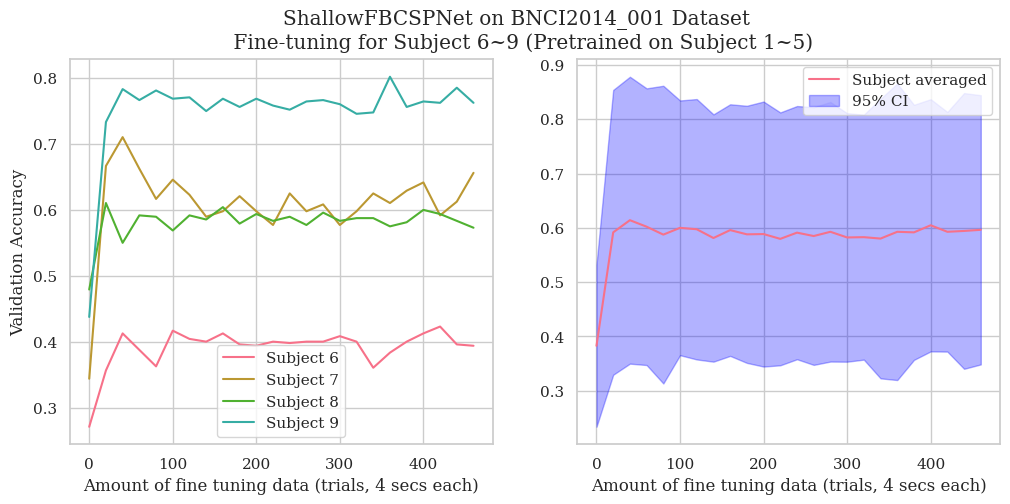

In [22]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

for subj_id, subj_res in dict_results.items():
    ax1.plot(subj_res.keys(), subj_res.values(), label=f'Subject {subj_id}')

ax1.legend()
ax1.set_xlabel('Amount of fine tuning data (trials, 4 secs each)')
ax1.set_ylabel('Validation Accuracy')

ax2.plot(subject_averaged_df, label='Subject averaged')
ax2.fill_between(subject_averaged_df.index, conf_interval_df[0], conf_interval_df[1], color='b', alpha=0.3, label='95% CI')
ax2.legend()
ax2.set_xlabel('Amount of fine tuning data (trials, 4 secs each)')

plt.suptitle('ShallowFBCSPNet on BNCI2014_001 Dataset \n Fine-tuning for Subject 6~9 (Pretrained on Subject 1~5)')

plt.savefig(os.path.join(results_dir, f'{file_name}.png'))